In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

matches = pd.read_csv('Data/match.csv', sep=",")
players = pd.read_csv('Data/players.csv', sep=",")



In [ ]:
len(matches)

In [321]:
len(players)

500000

In [234]:
intermediary_join = pd.merge(matches, players, on='match_id', how='inner')

In [235]:
drop_columns = ['match_id', 'account_id', 'start_time', 'first_blood_time', 'game_mode', 'negative_votes', 'positive_votes', 'cluster', 'player_slot', 'stuns',
           'item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'leaver_status', 'unit_order_none', 'unit_order_move_to_position',
           'unit_order_move_to_target', 'unit_order_attack_move', 'unit_order_attack_target', 'unit_order_cast_position',
           'unit_order_cast_target', 'unit_order_cast_target_tree', 'unit_order_cast_no_target',
       'unit_order_cast_toggle', 'unit_order_hold_position',
       'unit_order_train_ability', 'unit_order_drop_item',
       'unit_order_give_item', 'unit_order_pickup_item',
       'unit_order_pickup_rune', 'unit_order_purchase_item',
       'unit_order_sell_item', 'unit_order_disassemble_item',
       'unit_order_move_item', 'unit_order_cast_toggle_auto',
       'unit_order_stop', 'unit_order_taunt', 'unit_order_buyback',
       'unit_order_glyph', 'unit_order_eject_item_from_stash',
       'unit_order_cast_rune', 'unit_order_ping_ability',
       'unit_order_move_to_direction', 'unit_order_patrol',
       'unit_order_vector_target_position', 'unit_order_radar',
       'unit_order_set_item_combine_lock', 'unit_order_continue']
intermediary_join.drop(drop_columns, inplace=True, axis=1)


In [236]:
intermediary_join = intermediary_join.sample(frac=1).reset_index(drop=True)

training_labels = intermediary_join['radiant_win']

training_labels = intermediary_join['radiant_win'][:450000].values.reshape(450000, 1)
test_labels = intermediary_join['radiant_win'][450001:].values.reshape(49999, 1)


In [322]:
intermediary_join.columns

Index(['duration', 'tower_status_radiant', 'tower_status_dire',
       'barracks_status_dire', 'barracks_status_radiant', 'hero_id', 'gold',
       'gold_spent', 'gold_per_min', 'xp_per_min', 'kills', 'deaths',
       'assists', 'denies', 'last_hits', 'hero_damage', 'hero_healing',
       'tower_damage', 'level', 'xp_hero', 'xp_creep', 'xp_roshan', 'xp_other',
       'gold_other', 'gold_death', 'gold_buyback', 'gold_abandon', 'gold_sell',
       'gold_destroying_structure', 'gold_killing_heros',
       'gold_killing_creeps', 'gold_killing_roshan', 'gold_killing_couriers'],
      dtype='object')

In [237]:
intermediary_join.drop('radiant_win', inplace=True, axis=1)

training_data = intermediary_join

training_data = intermediary_join[:450000].values.reshape(450000, 33)
test_data = intermediary_join[450001:].values.reshape(49999, 33)


In [238]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer


imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(training_data)

training_data_imp = imp.transform(training_data)
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=50, n_jobs=-1, oob_score = True)
clf = clf.fit(training_data_imp, training_labels.ravel())


In [239]:
imp2 = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp2 = imp2.fit(test_data)
test_data_imp = imp2.transform(test_data)

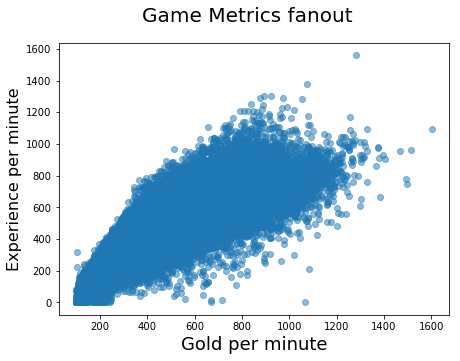

In [341]:
fig = plt.figure(figsize=(7, 5))
plt.scatter(intermediary_join['gold_per_min'], intermediary_join['xp_per_min'], alpha=0.5, );
fig.suptitle('Game Metrics fanout', fontsize=20)
plt.xlabel('Gold per minute', fontsize=18)
plt.ylabel('Experience per minute', fontsize=16)


In [343]:
intermediary_join.hero_id.value_counts

<bound method IndexOpsMixin.value_counts of 0         100
1           2
2          98
3          39
4          61
5          82
6          46
7          88
8           7
9          67
10         31
11         73
12         46
13         74
14         45
15         87
16         62
17         68
18         59
19         26
20         28
21         53
22         50
23         11
24        106
25         15
26         61
27         36
28         85
29         50
         ... 
499970    111
499971      8
499972     51
499973     94
499974     46
499975     12
499976     81
499977     87
499978     72
499979    107
499980     11
499981     36
499982     11
499983     62
499984    104
499985    106
499986     28
499987     21
499988     21
499989     21
499990     26
499991    100
499992      7
499993     11
499994     11
499995    112
499996      7
499997     50
499998     46
499999      5
Name: hero_id, Length: 500000, dtype: int64>

In [240]:
predictions = clf.predict(test_data_imp)

In [241]:
accuracy = np.logical_and(predictions, np.squeeze(test_labels).shape)

In [252]:
np.sum(accuracy == predictions)

49999

In [249]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = metrics.roc_curve(predictions, test_labels)

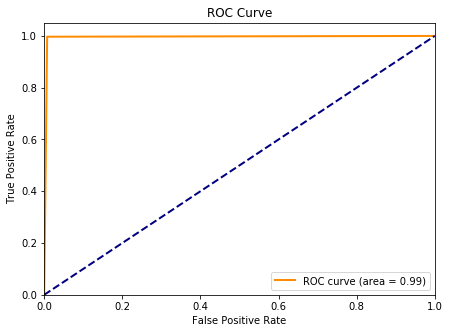

In [326]:
plt.figure(figsize=(7, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [311]:
feature_importance = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance['Feature'] = intermediary_join.columns
feature_importance['Importance'] = clf.feature_importances_

,Feature,Importance
0,duration,0.003778
1,tower_status_radiant,0.334887
2,tower_status_dire,0.245480
3,barracks_status_dire,0.211603
4,barracks_status_radiant,0.196647
5,hero_id,0.000038
6,gold,0.000208
7,gold_spent,0.000323
8,gold_per_min,0.000135
9,xp_per_min,0.000163


In [323]:
feature_importance.sort_values(['Importance'], ascending=False, inplace=True)
feature_importance.index = range(1,len(feature_importance) + 1)
feature_importance.head(10)

,Feature,Importance
1,tower_status_radiant,0.334887
2,tower_status_dire,0.245480
3,barracks_status_dire,0.211603
4,barracks_status_radiant,0.196647
5,duration,0.003778
6,gold_destroying_structure,0.001522
7,level,0.001177
8,gold_killing_roshan,0.000611
9,xp_creep,0.000547
10,gold_death,0.000538


In [319]:
feature_importance.loc[feature_importance['Feature'] == 'hero_id']

,Feature,Importance
28,hero_id,0.000038
